### Evaluación de los tres modelos de regresión utilizados

- Regresión Lineal
- Máquinas de Vectores de soporte(Regresión)
- Random Forest (Regresión)

### Importacion de librerías

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib
import os


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preparación de datos
# ==============================================================================
from sklearn.neighbors import LocalOutlierFactor
import statsmodels.api as sm

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error


#Evaluación del modelo
from sklearn import metrics
#from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn import svm


#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import sys
from funciones import multiple_plot, plot_roc_curve

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

### Cargue del dataset de pruebas y de entrenamiento

In [3]:
#Carga del dataset
dp=pd.read_csv('3_Fuel_Consumption_2000-2022_Prue.csv')
dp.shape
d = pd.read_csv('3_Fuel_Consumption_2000-2022_Prep.csv')
d.shape

(14093, 9)

In [4]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              1566 non-null   int64  
 1   RANGE_CATEGORY    1566 non-null   object 
 2   VEHICLE CLASS     1566 non-null   object 
 3   ENGINE SIZE       1566 non-null   float64
 4   CYLINDERS         1566 non-null   int64  
 5   FUEL              1566 non-null   object 
 6   FUEL CONSUMPTION  1566 non-null   float64
 7   KMXGALON          1566 non-null   float64
 8   EMISSIONS         1566 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 110.2+ KB


### Variables de entrada

In [5]:
#Lista de variables categóricas
catCols = dp.select_dtypes(include = ["object", 'category']).columns.tolist()

dp[catCols].head(2)

,RANGE_CATEGORY,VEHICLE CLASS,FUEL
0,HIGH_RANGE,MIDSIZE_FULLSIZE,Z
1,HIGH_RANGE,MIDSIZE_FULLSIZE,Z


In [6]:
#Lista de variables numéricas

numCols=dp.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

dp[numCols].head(2)

,YEAR,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,KMXGALON,EMISSIONS
0,2000,2.7,6,13.6,40.23350,264
1,2000,2.7,6,13.6,38.62416,267


## Modelo de Regresión Linear

### Eliminación variable de salida

In [7]:
numCols.remove('EMISSIONS')

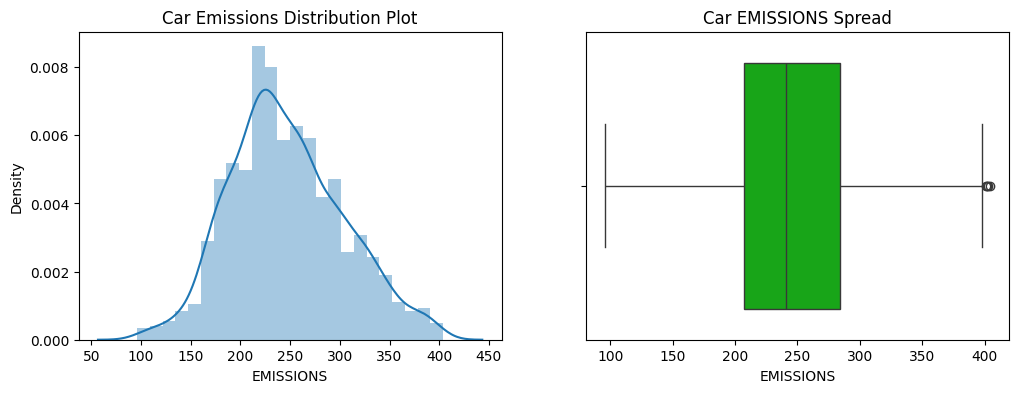

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Emissions Distribution Plot')
sns.distplot(dp.EMISSIONS)

plt.subplot(1,2,2)
plt.title('Car EMISSIONS Spread')
sns.boxplot(x=dp.EMISSIONS, palette='nipy_spectral')

plt.show()

In [9]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(dp.EMISSIONS.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count   1566
mean     247
std       57
min       96
25%      207
50%      241
75%      284
85%      312
90%      326
95%      350
97.5%    371
100%     404
max      404
Name: EMISSIONS, dtype: float64


### Transformación de datos

In [10]:
#Tranformacion y = y^(1/3) Raiz cúbica
dp['EMISSIONS'] = np.cbrt(dp['EMISSIONS'])

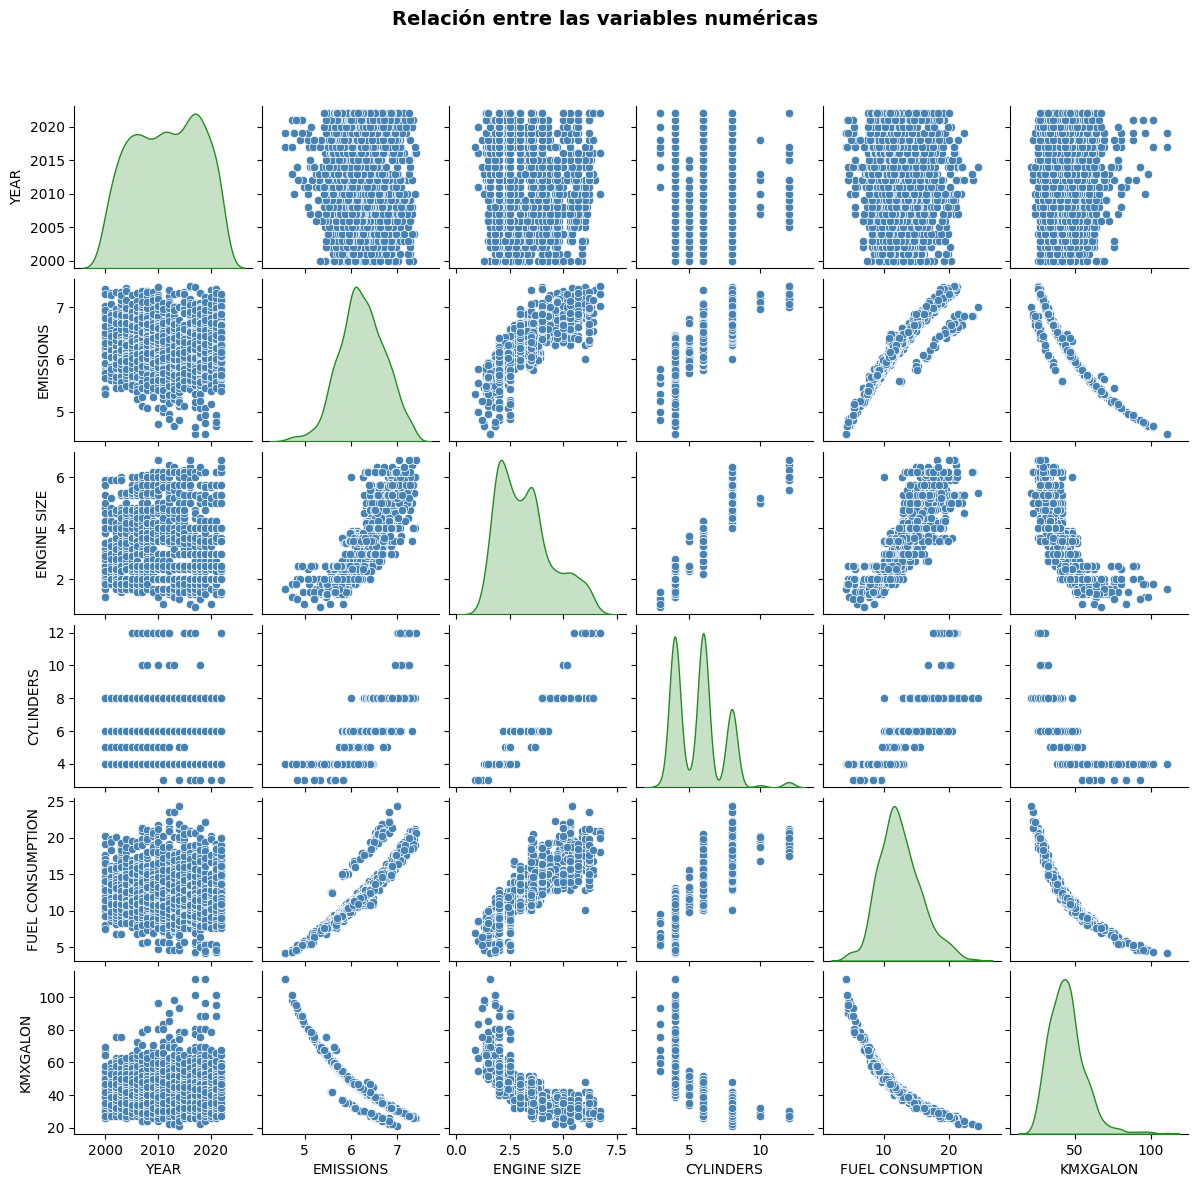

In [11]:
varTrans = ['YEAR','EMISSIONS','ENGINE SIZE', 'CYLINDERS','FUEL CONSUMPTION','KMXGALON']

multiple_plot(1, dp , varTrans, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [12]:
#varTrans = ['EMISSIONS','ENGINE SIZE', 'CYLINDERS','FUEL CONSUMPTION','KMXGALON']
dp['ENGINE SIZE'] =  np.log(dp['ENGINE SIZE'])
dp['FUEL CONSUMPTION'] = np.log(dp['FUEL CONSUMPTION'])
dp['KMXGALON'] = np.log(dp['KMXGALON'])
dp['CYLINDERS'] = np.log(dp['CYLINDERS'])
dp['YEAR'] = np.log(dp['YEAR'])

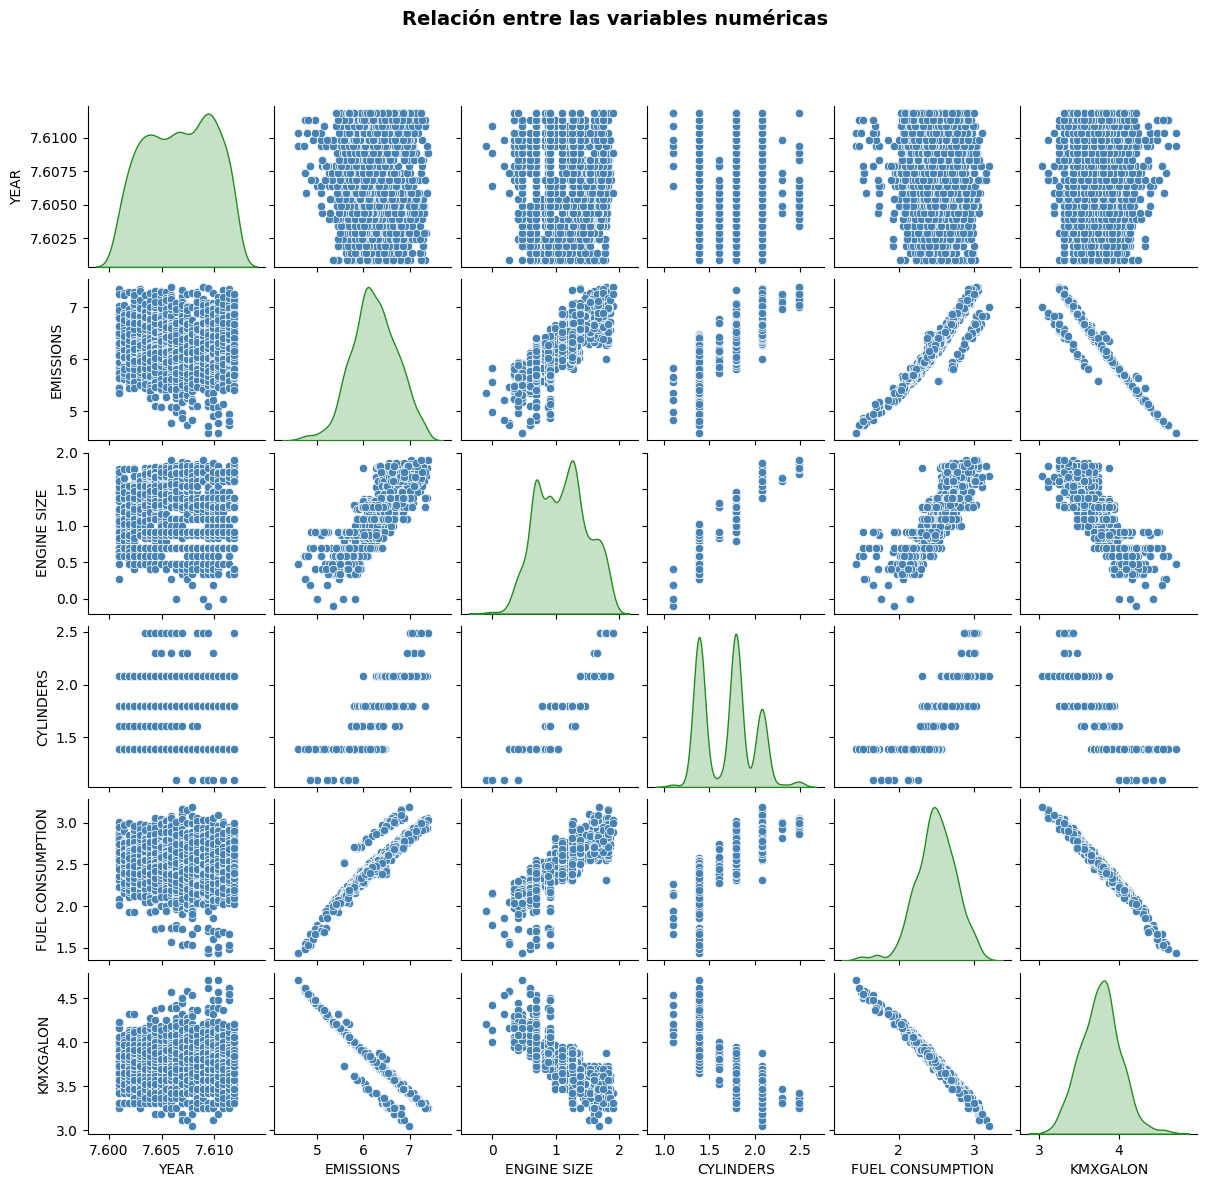

In [13]:
multiple_plot(1, dp , varTrans, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [14]:

from funciones import multiple_plot, plot_roc_curve, tidy_corr_matrix, checkVIF
matrizCorr = dp[['EMISSIONS']+numCols].corr()
df_corr= tidy_corr_matrix(matrizCorr)

df_filtrado = df_corr.loc[df_corr['variable_2'] == 'EMISSIONS']
df_filtrado[df_filtrado['abs_r']>=0.5]
VarRelevantes = df_filtrado[df_filtrado['abs_r']>=0.5].shape[0]

vDep =df_filtrado['variable_1'][:VarRelevantes].tolist()
print(vDep)

['KMXGALON', 'FUEL CONSUMPTION', 'ENGINE SIZE', 'CYLINDERS']


In [15]:
vDep += catCols

In [16]:
dp = dp[vDep  +['EMISSIONS']]
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   KMXGALON          1566 non-null   float64
 1   FUEL CONSUMPTION  1566 non-null   float64
 2   ENGINE SIZE       1566 non-null   float64
 3   CYLINDERS         1566 non-null   float64
 4   RANGE_CATEGORY    1566 non-null   object 
 5   VEHICLE CLASS     1566 non-null   object 
 6   FUEL              1566 non-null   object 
 7   EMISSIONS         1566 non-null   float64
dtypes: float64(5), object(3)
memory usage: 98.0+ KB


In [17]:
dp = pd.get_dummies(dp, dtype=int ,drop_first=1)

In [18]:
#Se crea una lista con todas las varibles de entrada

vDep = list(dp.columns)
vDep.remove('EMISSIONS')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = dp.drop(columns ='EMISSIONS')
y = dp['EMISSIONS']

In [19]:
num_vars = list(set(numCols) & set(vDep))


In [20]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = joblib.load('scaler/minmaxLinearRegresion.pkl')

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X[num_vars] = scaler.fit_transform(X[num_vars])
X.head()

,KMXGALON,FUEL CONSUMPTION,ENGINE SIZE,CYLINDERS,RANGE_CATEGORY_LOW_RANGE,RANGE_CATEGORY_MID_RANGE,VEHICLE CLASS_SEDAN_COMPACT,VEHICLE CLASS_SUV_CROSSOVER,VEHICLE CLASS_TRUCK_VAN,VEHICLE CLASS_WAGON_SPECIALTY,FUEL_X,FUEL_Z
0,0.3918,0.6678,0.5473,0.5000,0,0,0,0,0,0,0,1
1,0.3673,0.6678,0.5473,0.5000,0,0,0,0,0,0,0,1
2,0.3673,0.6678,0.5473,0.5000,0,0,1,0,0,0,0,1
3,0.4379,0.6107,0.5089,0.5000,0,0,1,0,0,0,0,1
4,0.2581,0.8176,0.8441,0.7075,0,0,1,0,0,0,0,1


In [21]:
X = X.drop(["ENGINE SIZE"], axis = 1)
X = X.drop(["VEHICLE CLASS_WAGON_SPECIALTY"], axis = 1)
X = X.drop(["VEHICLE CLASS_SEDAN_COMPACT"], axis = 1)
X = X.drop(["KMXGALON"], axis = 1)

In [22]:
modelLRegresion = joblib.load('modelos/LinealRegression.pkl')

### Resultados de Regresión Lineal

In [23]:
X = sm.add_constant(X)

#Reducción de dimensionalidad del dataset: se convierte en una dimensión
y = y

#Se realiza la predicción sobre los datos de entrenamiento
prediccion_train = modelLRegresion.predict(X)

mse_train = mean_squared_error(y, prediccion_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y, prediccion_train)
medae_train = median_absolute_error(y, prediccion_train)
r2_train = r2_score(y, prediccion_train)

print("RESULTADOS TRAIN")
print(f"MSE   : {mse_train:.4f}")
print(f"RMSE  : {rmse_train:.4f}")
print(f"MAE   : {mae_train:.4f}")
print(f"MedAE : {medae_train:.4f}")
print(f"R2    : {r2_train:.4f}")

#Se calculan los residuos: diferencia entre la prediccion y el valor real en los datos de entreanamiento
residuos_train   = prediccion_train - y

RESULTADOS TRAIN
MSE   : 0.0198
RMSE  : 0.1408
MAE   : 0.1119
MedAE : 0.1015
R2    : 0.9170


In [24]:
#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

predicciones = modelLRegresion.predict(X)

# Concatenar X y y
df_prep = pd.DataFrame(np.c_[X, y], columns= X.columns.tolist()+['EMISSIONS'])
df_prep

,const,FUEL CONSUMPTION,CYLINDERS,RANGE_CATEGORY_LOW_RANGE,RANGE_CATEGORY_MID_RANGE,VEHICLE CLASS_SUV_CROSSOVER,VEHICLE CLASS_TRUCK_VAN,FUEL_X,FUEL_Z,EMISSIONS
0,1.0000,0.6678,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,6.4151
1,1.0000,0.6678,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,6.4393
2,1.0000,0.6678,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,6.4393
3,1.0000,0.6107,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,6.1885
4,1.0000,0.8176,0.7075,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,6.9174
...,...,...,...,...,...,...,...,...,...,...
1561,1.0000,0.4204,0.2075,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,5.6877
1562,1.0000,0.5871,0.2075,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,6.1885
1563,1.0000,0.4332,0.2075,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,5.6980
1564,1.0000,0.5625,0.2075,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,6.0732


In [25]:
# Predecir los valores para df_prep utilizando el modelLRegresion y Elevar al cubo usando np.power()
resultadoPredict =np.power(modelLRegresion.predict(df_prep.drop(columns ='EMISSIONS')), 3)
resultadoPredict

0      279.9642
1      279.9642
2      279.9642
3      258.5948
4      350.1279
         ...   
1561   193.2812
1562   237.9814
1563   187.0497
1564   229.5986
1565   235.8725
Length: 1566, dtype: float64

In [26]:
# Convertir el array numpy resultadoPredic en un DataFrame de pandas
resultadoPredict_df = pd.DataFrame(resultadoPredict, columns=['EMISSIONS_Predicted'])
resultadoPredict_df

,EMISSIONS_Predicted
0,279.9642
1,279.9642
2,279.9642
3,258.5948
4,350.1279
...,...
1561,193.2812
1562,237.9814
1563,187.0497
1564,229.5986


In [27]:
# Concatenar x_i con el DataFrame de las predicciones
concatenated_df = pd.concat([df_prep.reset_index(drop=True), resultadoPredict_df], axis=1)

# El valor de Y real se eleva al cubo
concatenated_df['EMISSIONS'] = np.power(concatenated_df['EMISSIONS'],3)

In [28]:
# Se calcula el valor absoluto de la diferencia entre el Y real y el Y calculado
concatenated_df['dif'] = (concatenated_df['EMISSIONS'] - concatenated_df['EMISSIONS_Predicted']).abs()

In [29]:
# Las diferencias ordenadas
concatenated_df[['EMISSIONS', 'EMISSIONS_Predicted', 'dif']].sort_values(by='dif', ascending=True)

,EMISSIONS,EMISSIONS_Predicted,dif
1246,236.0000,235.9898,0.0102
1382,318.0000,317.9810,0.0190
1440,318.0000,317.9810,0.0190
1119,207.0000,206.9592,0.0408
25,207.0000,206.9592,0.0408
...,...,...,...
1533,263.0000,195.0571,67.9429
1136,255.0000,186.8992,68.1008
1262,268.0000,196.9234,71.0766
1514,272.0000,196.9234,75.0766


## Evaluación de los otros modelos

In [30]:
#Carga del dataset
dp=pd.read_csv('3_Fuel_Consumption_2000-2022_Prue.csv')
dp.shape
d = pd.read_csv('3_Fuel_Consumption_2000-2022_Prep.csv')
d.shape

(14093, 9)

In [31]:
#Lista de variables categóricas
catCols = dp.select_dtypes(include = ["object", 'category']).columns.tolist()

dp[catCols].head()

,RANGE_CATEGORY,VEHICLE CLASS,FUEL
0,HIGH_RANGE,MIDSIZE_FULLSIZE,Z
1,HIGH_RANGE,MIDSIZE_FULLSIZE,Z
2,HIGH_RANGE,SEDAN_COMPACT,Z
3,HIGH_RANGE,SEDAN_COMPACT,Z
4,HIGH_RANGE,SEDAN_COMPACT,Z


In [32]:
numCols=dp.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
dp[numCols].head()

,YEAR,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,KMXGALON,EMISSIONS
0,2000,2.7000,6,13.6000,40.2335,264
1,2000,2.7000,6,13.6000,38.6242,267
2,2000,2.7000,6,13.6000,38.6242,267
3,2000,2.5000,6,12.3000,43.4522,237
4,2000,4.9000,8,17.7000,32.1868,331


In [33]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('EMISSIONS')

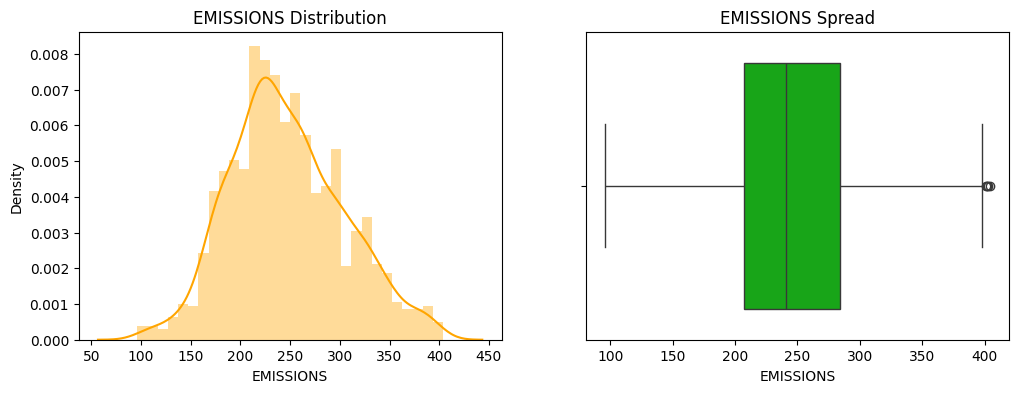

In [34]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('EMISSIONS Distribution')
sns.distplot(dp.EMISSIONS, color='orange', bins=30)

plt.subplot(1,2,2)
plt.title('EMISSIONS Spread')
sns.boxplot(x=dp.EMISSIONS, palette='nipy_spectral')

plt.show()

In [35]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(dp.EMISSIONS.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count   1566
mean     247
std       57
min       96
25%      207
50%      241
75%      284
85%      312
90%      326
95%      350
97.5%    371
100%     404
max      404
Name: EMISSIONS, dtype: float64


In [36]:
dp =pd.get_dummies(dp, drop_first=1)

In [37]:
X = dp.drop(columns = "EMISSIONS")
y = dp['EMISSIONS']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

num_vars = numCols


In [39]:
dp =pd.get_dummies(dp, drop_first=1)
d =pd.get_dummies(d, drop_first=1)
missingCols = set(d.columns) - set(dp.columns)
missingCols


set()

In [40]:
for col in missingCols:
    dp[col] = 0

In [41]:
Xp = dp.drop(columns ='EMISSIONS')
yp = dp['EMISSIONS']

In [42]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Cargar el scaler

scaler = joblib.load('scaler/minmaxRandomForest.pkl')

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
Xp[numCols] = scaler.transform(Xp[numCols])

Xp[numCols].head(2)

,YEAR,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,KMXGALON
0,0.0000,0.2297,0.4000,0.3966,0.2281
1,0.0000,0.2297,0.4000,0.3966,0.2105


In [43]:
ruta_modelos = 'modelos'

In [44]:
modelos_cargados = []

dr = pd.DataFrame()
ruta_completa = 'modelos/RForest_CV.pkl'

modelo_cargado = joblib.load(ruta_completa)

entrenamiento_features = modelo_cargado.feature_names_in_
Xp = Xp[entrenamiento_features]

y_pred = modelo_cargado.predict(Xp)

nuevoModelo = {
    'model': 'RForest_CV.pkl',                                 
    'Descripcion': modelo_cargado,                           
    'r2_score': metrics.r2_score(yp, y_pred),                
    'mae': metrics.mean_absolute_error(yp, y_pred),          
    'rmse': np.sqrt(metrics.mean_squared_error(yp, y_pred))  
}

# Agrega la información del modelo y sus métricas al DataFrame.
dr = pd.concat([dr, pd.DataFrame([nuevoModelo])], ignore_index=True)

# Devuelve el DataFrame con los modelos y métricas procesados.
dr.sort_values(by='r2_score', ascending=False)

,model,Descripcion,r2_score,mae,rmse
0,RForest_CV.pkl,"(DecisionTreeRegressor(max_depth=12, max_featu...",0.9975,1.9400,2.8335


In [48]:
# Inicializa una lista vacía para almacenar los modelos cargados.
modelos_cargados = []

# Crea un DataFrame vacío para almacenar resultados y métricas de los modelos.
dr = pd.DataFrame()

# Itera sobre los archivos en la ruta especificada (ruta_modelos).
for archivo_modelo in os.listdir(ruta_modelos):
    # Verifica si el archivo es un modelo con extensión '.pkl' (archivos serializados con joblib).
    if archivo_modelo.endswith('.pkl') and archivo_modelo != 'LinealRegression.pkl':
        # Construye la ruta completa al archivo del modelo.
        ruta_completa = os.path.join(ruta_modelos, archivo_modelo)

        # Carga el modelo utilizando joblib. Esto devuelve el modelo previamente entrenado.
        modelo_cargado = joblib.load(ruta_completa)

        # Recupera las características utilizadas durante el entrenamiento del modelo.
        # Esto asegura que las predicciones usen el mismo conjunto de características en el mismo orden.
        entrenamiento_features = modelo_cargado.feature_names_in_

        # Filtra y reordena las características del conjunto de datos `Xp` según las del modelo cargado.
        Xp = Xp[entrenamiento_features]

        # Realiza predicciones utilizando el modelo cargado con los datos filtrados y reordenados.
        y_pred = modelo_cargado.predict(Xp)


        # Crea un diccionario con información sobre el modelo y métricas de rendimiento.
        nuevoModelo = {
            'model': archivo_modelo,                                 # Nombre del archivo del modelo.
            'Descripcion': modelo_cargado,                           # Modelo cargado (objeto).
            'r2_score': metrics.r2_score(yp, y_pred),                # Coeficiente de determinación R².
            'mae': metrics.mean_absolute_error(yp, y_pred),          # Error absoluto medio (MAE).
            'rmse': np.sqrt(metrics.mean_squared_error(yp, y_pred))  # Raíz del error cuadrático medio (RMSE).
        }

        # Agrega la información del modelo y sus métricas al DataFrame.
        dr = pd.concat([dr, pd.DataFrame([nuevoModelo])], ignore_index=True)

# Devuelve el DataFrame con los modelos y métricas procesados.
dr.sort_values(by='r2_score', ascending=False)

,model,Descripcion,r2_score,mae,rmse
0,RForest_CV.pkl,"(DecisionTreeRegressor(max_depth=12, max_featu...",0.9975,1.9400,2.8335
1,SVRModel.pkl,"SVR(C=np.float64(1000.0), gamma=1)",0.9973,2.1204,2.9521
